In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Concatenate, Add, AveragePooling2D
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2023-12-30 12:34:22.045108: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-30 12:34:22.111172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-30 12:34:22.111203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-30 12:34:22.112758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-30 12:34:22.122363: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-12-30 12:34:24.506812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-30 12:34:24.586523: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-30 12:34:24.586731: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
import matplotlib.pyplot as plt

In [2]:

# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

#feats = np.load(feats_path)
#print("feats shape: ", feats.shape)
y = y[:, 0] # only use laser power
print("y shape: ", y.shape)

# normalize y
y = y / np.max(y)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
y shape:  (9587,)


In [3]:
# unique values in y
y_unique = np.unique(y)
print("unique values in y: ", y_unique)

# encode y as integers based on unique values
y_encoded = np.zeros(y.shape)
for i in range(len(y_unique)):
    y_encoded[y == y_unique[i]] = i
print("y encoded: ", y_encoded)
# change to int
y_encoded = y_encoded.astype(int)

# print typr of y_encoded
print("y encoded type: ", type(y_encoded[0]))

unique values in y:  [0.18181818 0.45454545 0.72727273 1.        ]
y encoded:  [0. 0. 0. ... 3. 3. 3.]
y encoded type:  <class 'numpy.int64'>


In [4]:
# crate pairs
def create_pairs(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    pairs = []
    labels = []
    
    # Getting the indices of each class
    numclasses = len(np.unique(y_encoded))
    idx = [np.where(y_encoded==i)[0] for i in range(numclasses)]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label = y_encoded[idxA]

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(idx[label])
        posImage = xiris[idxB]

        # prepare a positive pair and update the images and labels lists, respectively
        pairs.append([currentImage, posImage])
        labels.append([1])

        # grab the indices for each of the class labels not equal to the current label
        negIdx = np.where(y_encoded != label)[0]
        
        # check if the indices in negIdx are valid for xiris
        valid_negIdx = [idx for idx in negIdx if idx < len(xiris)]
        
        # randomly pick an image corresponding to a label not equal to the current label
        negImage = xiris[np.random.choice(valid_negIdx)]
        
        # prepare a negative pair of images and update our lists
        pairs.append([currentImage, negImage])
        labels.append([0])

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(pairs), np.array(labels)       

                                                                                             
# create pairs
pairs, labels = create_pairs(manta, xiris, y_encoded)
print("pairs shape: ", pairs.shape)
print("labels shape: ", labels.shape)

# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, shuffle=True)
print(f"X_train shape: {X_train.shape} ",f"y_train shape: {y_train.shape} ")
print(f"X_test shape: {X_test.shape} ",f"y_test shape: {y_test.shape} ")


Creating pairs for image 0/9587, Completed 0%
Creating pairs for image 1000/9587, Completed 10%
Creating pairs for image 2000/9587, Completed 20%
Creating pairs for image 3000/9587, Completed 31%
Creating pairs for image 4000/9587, Completed 41%
Creating pairs for image 5000/9587, Completed 52%
Creating pairs for image 6000/9587, Completed 62%
Creating pairs for image 7000/9587, Completed 73%
Creating pairs for image 8000/9587, Completed 83%
Creating pairs for image 9000/9587, Completed 93%
pairs shape:  (19174, 2, 320, 320)
labels shape:  (19174, 1)
X_train shape: (15339, 2, 320, 320)  y_train shape: (15339, 1) 
X_test shape: (3835, 2, 320, 320)  y_test shape: (3835, 1) 


In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(ops.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

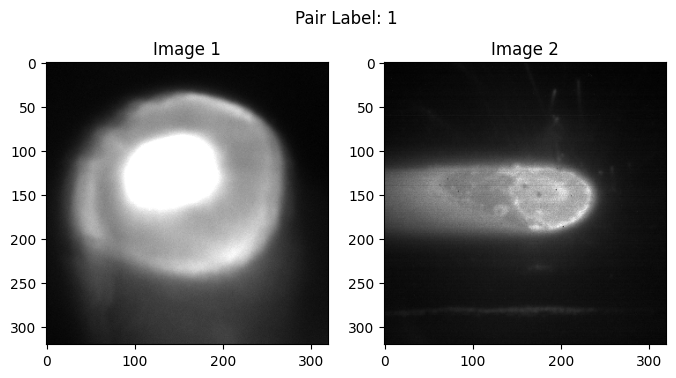

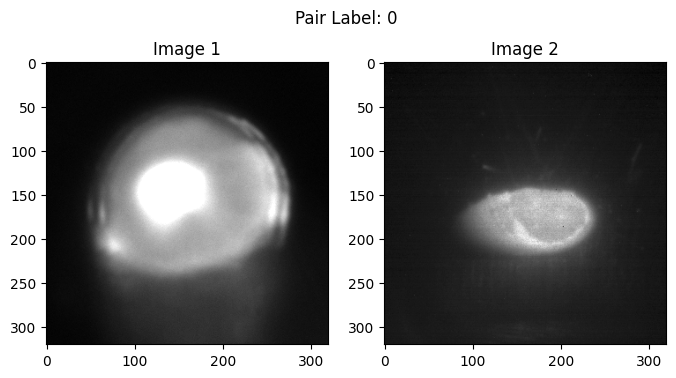

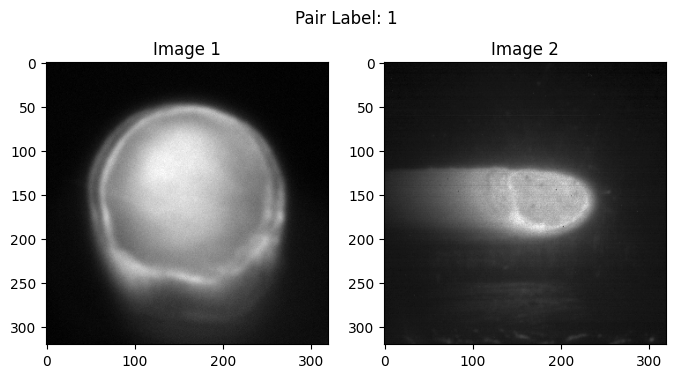

In [5]:
# Verify a few pairs visually
num_samples_to_verify = 3

for i in range(num_samples_to_verify):
    sample_idx = np.random.randint(0, len(X_train))
    pair = X_train[sample_idx]
    label = y_train[sample_idx]

    # Extract images from the pair
    image1, image2 = pair[0], pair[1]

    # Display images with their corresponding label
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')

    plt.suptitle(f"Pair Label: {label[0]}")
    plt.show()


In [6]:
def create_triples(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    triples = []
    
    # Getting the indices of each class
    numclasses = len(np.unique(y_encoded))
    idx = [np.where(y_encoded==i)[0] for i in range(numclasses)]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label = y_encoded[idxA]

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(idx[label])
        posImage = xiris[idxB]

        # grab the indices for each of the class labels not equal to the current label
        negIdx = np.where(y_encoded != label)[0]
        
        # check if the indices in negIdx are valid for xiris
        valid_negIdx = [idx for idx in negIdx if idx < len(xiris)]
        
        # randomly pick an image corresponding to a label not equal to the current label
        negImage = xiris[np.random.choice(valid_negIdx)]
        
        # prepare a negative pair of images and update our lists
        triples.append([currentImage, posImage, negImage])

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(triples) 


In [15]:
def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(124, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(248, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# add projection head
def add_projection_head(input_shape, encoder, embedding_dim):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    # add dense and dropout
    features = layers.Dense(512, activation='relu')(features)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(embedding_dim, activation='relu')(features)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
def euclidean_distance(vecs):
    """Find the Euclidean distance between two vectors. L2-distance.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """
    
    (imgA, imgB) = vecs
    
    # Calculate squared Euclidean distance
    squared_diff = tf.square(imgA - imgB)
    sum_squared_diff = tf.reduce_sum(squared_diff, axis=1, keepdims=True)
    
    # Take the square root with epsilon for numerical stability
    euclidean_dist = tf.sqrt(tf.maximum(sum_squared_diff, tf.keras.backend.epsilon()))
    
    return euclidean_dist       

def contrastiveloss(y, y_preds, margin=1):
    y = tf.cast(y, dtype=y_preds.dtype)

    # Calculate squared y_preds and margin
    y_preds_squared = tf.square(y_preds)
    margin_squared = tf.square(tf.maximum(margin - y_preds, 0))

    # Compute the loss
    return tf.reduce_mean(y * y_preds_squared + (1 - y) * margin_squared) # positive + negative loss

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
    
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [17]:
# L1 distante
def manhattan_distance(vecs):
    """Find the Manhattan distance between two vectors. L1-distance.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing manhattan distance
        (as floating point value) between vectors.
    """
    
    (imgA, imgB) = vecs
    
    # Calculate squared Euclidean distance
    abs_diff = tf.abs(imgA - imgB)
    sum_abs_diff = tf.reduce_sum(abs_diff, axis=1, keepdims=True)
    
    # Take the square root with epsilon for numerical stability
    manhattan_dist = tf.maximum(sum_abs_diff, tf.keras.backend.epsilon())
    
    return manhattan_dist

In [18]:
input_shape = (320, 320, 1)
embedding_dim=256
batch_size = 64
epochs = 10
learning_rate = 0.0001


manta = Input(shape=input_shape)
xiris = Input(shape=input_shape)

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)
#encoder_with_projection_head.summary()

manta_model = encoder_with_projection_head(manta)
xiris_model = encoder_with_projection_head(xiris)

# Calculate the distance between the two embeddings
distance = Lambda(euclidean_distance, output_shape=(1,))([manta_model, xiris_model]) # euclidean_distance #manhattan_distance
#output_layer = Dense(1, activation="linear")(distance) # linear activation"sigmoid"
model = Model(inputs=[manta, xiris], outputs=distance) #outputs=distance
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_4 (Functional)        (None, 256)                  7338944   ['input_5[0][0]',             
                                                          20         'input_6[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 1)                    0         ['model_4[0][0]',       

In [19]:
model.compile(loss=contrastiveloss, optimizer=tf.keras.optimizers.Adam(learning_rate))#, metrics=['accuracy'])
history = model.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/10
192/192 [==============================] - 66s 336ms/step - loss: 0.6815 - val_loss: 0.3250
Epoch 2/10
192/192 [==============================] - 60s 314ms/step - loss: 0.2348 - val_loss: 0.2871
Epoch 3/10
192/192 [==============================] - 60s 315ms/step - loss: 0.2246 - val_loss: 0.2598
Epoch 4/10
192/192 [==============================] - 60s 315ms/step - loss: 0.2211 - val_loss: 0.2967
Epoch 5/10
192/192 [==============================] - 60s 314ms/step - loss: 0.2149 - val_loss: 0.2618
Epoch 6/10
192/192 [==============================] - 60s 314ms/step - loss: 0.2105 - val_loss: 0.2582
Epoch 7/10
192/192 [==============================] - 60s 315ms/step - loss: 0.2038 - val_loss: 0.2612
Epoch 8/10
192/192 [==============================] - 60s 314ms/step - loss: 0.2033 - val_loss: 0.2391
Epoch 9/10
192/192 [==============================] - 60s 315ms/step - loss: 0.1993 - val_loss: 0.2421
Epoch 10/10
192/192 [==============================] - 60s 313ms/step - l

1/1 [==============================] - 0s 40ms/step


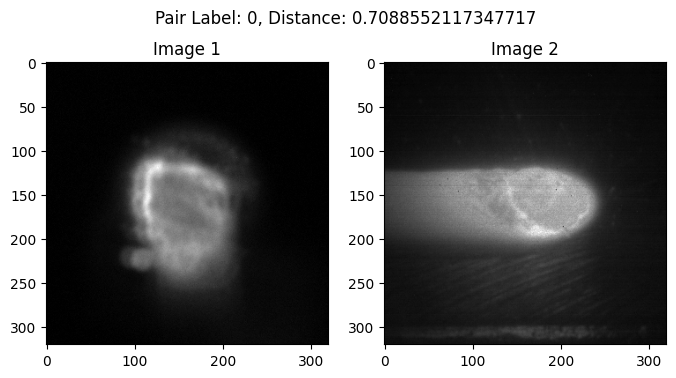

1/1 [==============================] - 0s 36ms/step


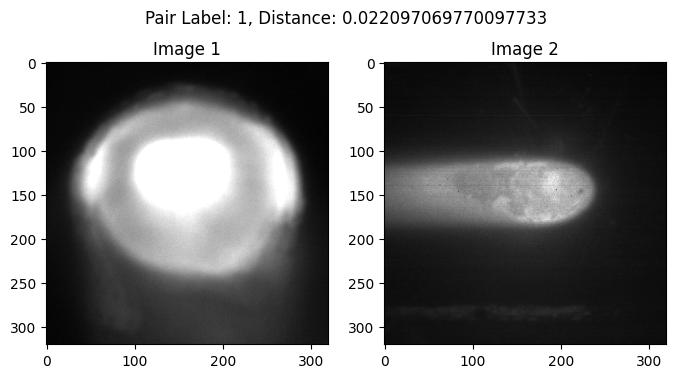

1/1 [==============================] - 0s 22ms/step


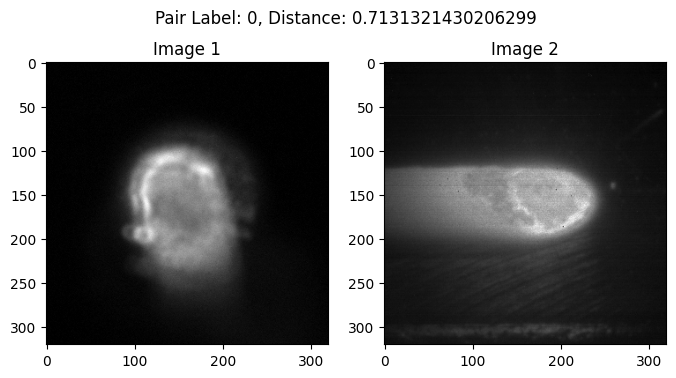

1/1 [==============================] - 0s 22ms/step


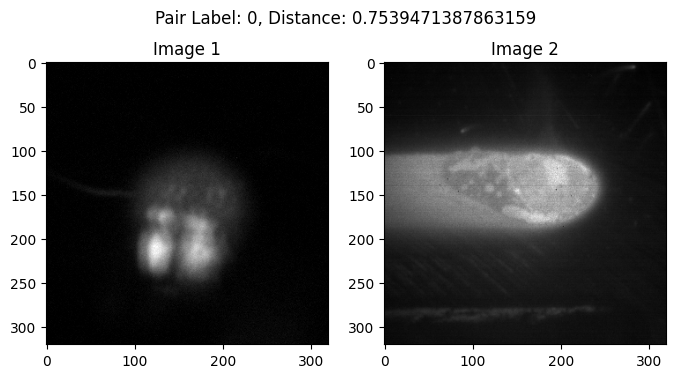

1/1 [==============================] - 0s 22ms/step


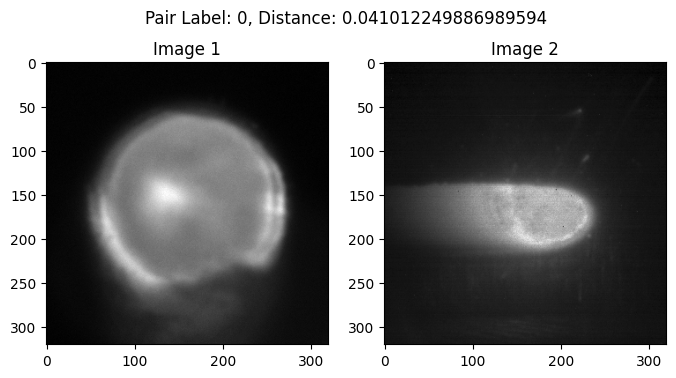

In [26]:
# with X_test display 3 pairs and their distance
num_samples_to_verify = 5

for i in range(num_samples_to_verify):
    sample_idx = np.random.randint(0, len(X_test))
    pair = X_test[sample_idx]
    label = y_test[sample_idx]

    # Extract images from the pair
    image1, image2 = pair[0], pair[1]

    # Display images with their corresponding label
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')

    

    # Calculate the distance between the two images
    distance = model.predict([np.expand_dims(image1, axis=0), np.expand_dims(image2, axis=0)])[0][0]
    
    
    plt.suptitle(f"Pair Label: {label[0]}, Distance: {distance}")
    plt.show()

In [21]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")


KeyError: 'accuracy'

In [ ]:
results = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print("test loss, test acc:", results)

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(ops.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [ ]:
predictions = model.predict([X_test[:, 0], X_test[:, 1]])
visualize(X_test, y_test, to_show=3, predictions=predictions, test=True)